## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns

!pip install mne
import mne

## Import Dataset

Data collected from [PiEEG](https://pieeg.com/pieeg/) device that allows reading EEG via RaspberryPi signle board computer.
Channel labels according to the international 10-20 system EEG Placement:
For EEG electrodes
* Ch1 - Fp1  
* Ch2 - Fp2
* Ch3 - T3  
* Ch4 - C3  
* Ch5 - Cz  
* Ch6 - C4     
* Ch7 - T4
* Ch8 - O1  
* Ch9 - O2   
and 2 clips electrodes (references and bias electrode)
* A1
* A2

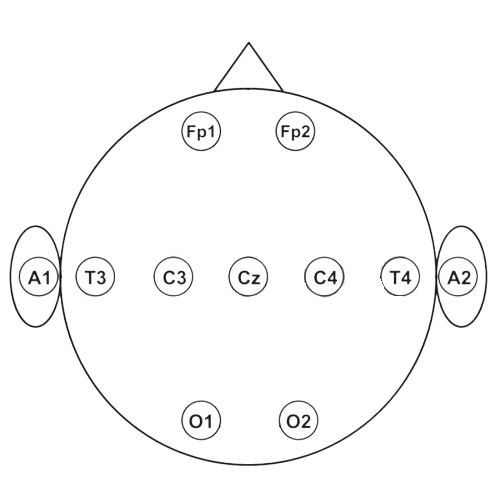

In [5]:
# Load Dataset as dataframe
eeg_data = pd.read_excel(r"C:\Users\odans\OneDrive\Documents\Specially applied course for signal processing with Python for Neuroscience, short way to start use EEG in life\Notebooks\dataset.xlsx")
print(eeg_data.head())

       ch1     ch2      ch3      ch4      ch5     ch6      ch7      ch8
0  23899.1  2951.1  36442.2  38418.6  12414.9  3759.5  31001.4  52775.3
1  23917.7  3048.0  36463.8  38344.3  12448.1  3726.3  31032.4  52223.4
2  23984.9  3148.2  36525.1  39002.6  12520.4  3601.3  31103.2  53175.1
3  24016.8  3183.3  36551.5  39602.8  12548.5  3473.0  31133.2  54514.6
4  23960.3  3061.0  36494.8  39256.9  12475.6  3549.7  31061.9  54321.3


## 1. Convert Digital ADC Values to Microvolts

To convert raw EEG data from the ADS1299 (24-bit ADC) into microvolts, we need to follow these steps:

### **Steps to Convert Digital ADC Values to Microvolts**
1. Normalize the ADC value:
   - The ADS1299 is a 24-bit ADC, so its values range from **0 to 16777216 _i.e.,_ \\( 2^24 \\)** (for unsigned data) and **-8388608 to 8388608** (for signed data).
   - Normalize the data by dividing the raw ADC value by its maximum range.

2. Scale to the reference voltage:
   - Multiply the normalized value by the reference voltage. Assume a **4.5V reference voltage**, as per your description.

3. Convert to microvolts:
   - Convert volts to microvolts by multiplying by \\( 10^6 \\).

4. Round to two decimal places for precision.or precision.

### What Are Signed and Unsigned Data?

- **Unsigned Data:** Unsigned data represents only non-negative values, ranging from **0 to \\( 2^x \\)** , where \\( x \\) is the number of bits. For a 24-bit ADC, the range is **0 to 16777216** . Unsigned data does not account for negative values.

- **Signed Data:** Signed data can represent both positive and negative values. It typically uses two’s complement representation, where the first bit indicates the sign (0 for positive, 1 for negative). For a 24-bit ADC, the range is -8388608 to -8388607, or -8388608 to 16777215. Signed data is necessary when dealing with bipolar signals.

#### **Define the Conversion Function**
- First, we will define a function `adc_to_microvolts()` that takes the raw ADC values (`adc_data`) and converts them to microvolts.
- The formula is:
  \\[
  \text{Microvolts} = 10^6 \cdot V_{\text{ref}} \cdot \left(\frac{\text{ADC Data}}{2^{24}}\right)
  \\]
  Where:
  - \\( V_{\text{ref}} \\) is the reference voltage (e.g., 4.5V).
  - \\( 2^{24} = 16777216 \\) is the maximum value for a 24-bit ADC.

In [9]:
# Convert raw EEG ADC data to microvolts
def adc_to_microvolts(adc_data, reference_voltage=4.5):
    """
    Convert raw ADC EEG data to microvolts.
    Parameters:
        adc_data (float): Raw ADC value.
        reference_voltage (float): Reference voltage in volts (default: 4.5V).
    Returns:
        float: EEG data in microvolts (rounded to 2 decimal places).
    """
    microvolts = 1000000 * reference_voltage * (adc_data / 16777216)
    return round(microvolts, 2)

eeg_data_microvolts = eeg_data.apply(adc_to_microvolts)

# Display the first few rows of the converted data
print("EEG Data in Microvolts:")
display(eeg_data_microvolts.head())

EEG Data in Microvolts:


,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,6410.24,791.55,9774.56,10304.67,3329.94,1008.38,8315.22,14155.44
1,6415.23,817.54,9780.35,10284.74,3338.84,999.47,8323.54,14007.41
2,6433.25,844.41,9796.80,10461.31,3358.23,965.94,8342.53,14262.67
3,6441.81,853.83,9803.88,10622.30,3365.77,931.53,8350.57,14621.96
4,6426.65,821.02,9788.67,10529.52,3346.22,952.10,8331.45,14570.11


## Visualization

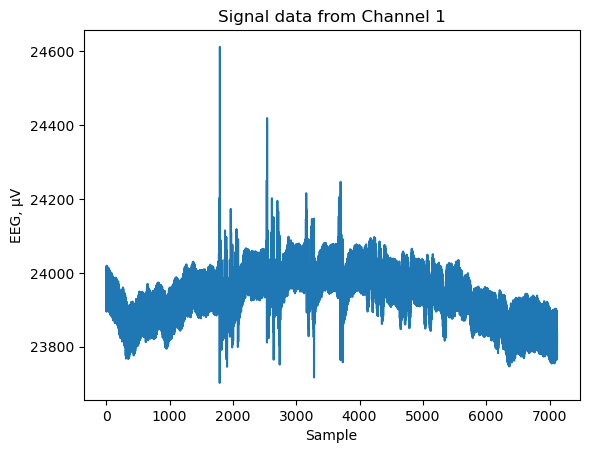

In [11]:
# select the data from the first channel for demo
channel = 0
channel_data = eeg_data.iloc[:, channel]

# plot the EEG data
plt.plot(channel_data)
plt.title("Signal data from Channel 1")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## 2. Inspect and Clean the Data

The goal of this step is to ensure the EEG data is free from inconsistencies, missing values, or invalid entries, and is formatted properly for further preprocessing.

### 2.1 Check for Missing Values
Missing values can occur due to sensor malfunctions or data corruption. It’s important to identify and handle these values.

In [13]:
# Check for missing values in the dataset
missing_values = eeg_data.isnull().sum()
print("Missing Values per Channel:\n", missing_values)

# Check the total number of missing values
total_missing = eeg_data.isnull().sum().sum()
print(f"Total Missing Values: {total_missing}")

Missing Values per Channel:
 ch1    0
ch2    0
ch3    0
ch4    0
ch5    0
ch6    0
ch7    0
ch8    0
dtype: int64
Total Missing Values: 0


Since there are no missing values, we will proceed to filtering the data

### **3. Filter the Data**

Filtering EEG data involves removing noise and irrelevant frequencies while retaining the signal components of interest. The two most common filters used in EEG preprocessing are:

1. **Bandpass Filter**: Retains frequencies within a specified range (e.g., 0.5–50 Hz for EEG).
2. **Notch Filter**: Removes specific frequencies, such as powerline noise (e.g., 50 Hz or 60 Hz).

---

#### **3.1 Bandpass Filtering**
A bandpass filter removes low-frequency drift and high-frequency noise while keeping the signal frequencies within a desired range.

The bandpass filter was implemented in two steps: 

1. **High-Pass Filtering**: This step removes low-frequency components below 1 Hz, such as baseline drift caused by slow movements or changes in electrode impedance.
2. **Low-Pass Filtering**: This step eliminates high-frequency noise above 10 Hz, including muscle activity, line noise, and environmental interferences.

The combination of these filters allows only frequencies between 1 Hz and 10 Hz to pass through, isolating the components most relevant to the analysis. These parameters were chosen based on the desired frequency range of interest, particularly for tasks involving slow EEG waveforms like delta and theta rhythms.

By applying this bandpass filter, we ensure that the EEG data is free from unwanted noise, enabling more accurate and reliable analysis in subsequent steps. The filtered data is now ready for visualization and further preprocessing steps, such as artifact removal. 

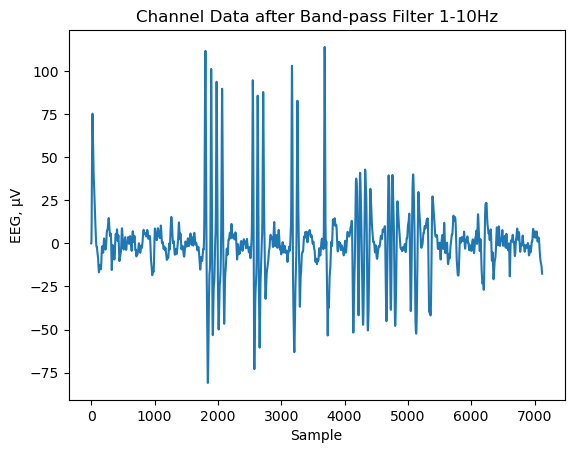

In [16]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 10  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_high,
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered,
    cutoff=cutoff_low,
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Channel Data after Band-pass Filter " + str(cutoff_high)+"-"+ str(cutoff_low)+"Hz")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

In [17]:
# Create a copy of the EEG data
eeg_data_filtered = eeg_data.copy()

# Apply high-pass and low-pass filters to each channel
for channel in eeg_data.columns:
    eeg_data_filtered[channel] = butter_lowpass_filter(
        butter_highpass_filter(eeg_data[channel], cutoff=cutoff_high, nyq=nyq, order=5),
        cutoff=cutoff_low, nyq=nyq, order=4
    )

# Display the first few rows of the filtered EEG data
display(eeg_data_filtered.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,0.004193,0.006562,0.004262,0.040693,0.004904,-0.008743,0.004608,0.065564
1,0.038157,0.071939,0.039288,0.323512,0.046740,-0.078439,0.043868,0.442722
2,0.183855,0.388659,0.189840,1.395010,0.231543,-0.371170,0.217646,1.573166
3,0.626880,1.392874,0.643128,4.524302,0.795371,-1.255770,0.750456,4.475601
4,1.671572,3.745164,1.695980,12.157474,2.107779,-3.378064,1.997940,11.869693


---
### **NOTE:**

The **Nyquist frequency** is a fundamental concept in signal processing that refers to the highest frequency that can be accurately captured when sampling a signal. It is equal to **half of the sampling rate** of the signal.

### Formula:
\\[
f_{\text{Nyquist}} = \frac{f_s}{2}
\\]
Where:
- \\( f_s \\) is the **sampling frequency** (the rate at which the signal is sampled per second, measured in Hz).

### Why Is It Important?
The Nyquist frequency plays a critical role in the **Nyquist-Shannon sampling theorem**, which states:
- To avoid **aliasing** (a distortion where high-frequency components are misrepresented as lower frequencies), the signal must be sampled at a rate at least **twice the highest frequency** present in the signal.

For example:
- If a signal contains frequencies up to 50 Hz, the sampling rate must be at least \\( 2 \times 50 = 100 \\) Hz to capture the signal accurately.

### Practical Explanation:
- When a signal is sampled at a rate \\( f_s \\), frequencies above the Nyquist frequency (\\( f_s/2 \\)) cannot be distinguished properly, and they "fold back" into the lower frequency range, causing aliasing.
- This is why **low-pass filters** (called anti-aliasing filters) are often used before sampling to remove frequencies above the Nyquist frequency.

### Example:
If the EEG signal is sampled at \\( f_s = 250 \, \text{Hz} \\):
- The Nyquist frequency is:
  \\[
  f_{\text{Nyquist}} = \frac{250}{2} = 125 \, \text{Hz}
  \\]
- This means the EEG signal can accurately capture frequencies up to 125 Hz.

### Understanding the `order` Parameter
In the context of **Butterworth filters** (or other filters), the `order` parameter determines the **steepness** of the filter's frequency response. 

### **What Does `order` Represent?**
- The **order** of a filter refers to the number of poles or the degree of the transfer function that defines the filter.
- A higher order filter has a **steeper roll-off** around the cutoff frequency, which means it attenuates frequencies outside the desired range more effectively.
- The roll-off rate increases by **6 dB per octave** for every additional order.

### **Practical Explanation:**
1. **First-order filter (order = 1):**
   - Provides a gentle slope with a roll-off rate of **6 dB per octave**.
   - Less effective at attenuating unwanted frequencies close to the cutoff.
2. **Second-order filter (order = 2):**
   - Steeper slope with a roll-off rate of **12 dB per octave**.
3. **Higher-order filters (order = 3, 4, etc.):**
   - The slope increases further, with **18 dB, 24 dB**, and so on per octave.

For example:
- A **low-pass filter** with order = 1 will have a gradual reduction in amplitude for frequencies above the cutoff.
- An **order = 5 filter** will sharply attenuate frequencies beyond the cutoff, providing better isolation of the desired frequency band.

 **In Our Code:**
```python
b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
```
- The `order` determines how sharply the high-pass and low-pass filters transition from passband to stopband.
- In the example, we use `order=5` for the high-pass filter and `order=4` for the low-pass filter. This provides a relatively steep roll-off for both filters, ensuring effective filtering of frequencies outside the band of interest.

### **Trade-offs of Choosing `order`:**
1. **Higher Order:**
   - Better attenuation of unwanted frequencies.
   - Potential for more ringing or phase distortion near the cutoff.
   - Increased computational cost.

2. **Lower Order:**
   - Smoother transition, less phase distortion.
   - Less effective at isolating frequencies near the cutoff.

In our case, using an **order of 5 for the high-pass filter** and **order of 4 for the low-pass filter** strikes a good balance between sharp filtering and stability for EEG signal preprocessing. 

---
### Expected Observations and Discussion

- **Lower Cutoff Frequencies:** Adjusting the high-pass filter to a lower cutoff frequency (e.g., 0.5 Hz) allows more low-frequency components to pass through.

- **Higher Cutoff Frequencies:** Adjusting the low-pass filter to a higher cutoff frequency (e.g., 7 Hz) allows more high-frequency components to pass through.

- **Filter Order:** Increasing the filter order sharpens the cutoff but may introduce phase distortions.

### Heat Map: Enhancing EEG Signal Visualization

A **heat map** provides a **spatial and temporal context** for understanding brain activity. Here's how it can help:

1. **Spatial and Temporal Context**:
   - Heat maps offer a color-coded representation of EEG data, allowing for an intuitive understanding of **how signal intensities vary across channels over time**.
   - This can reveal **spatial patterns** of activity (e.g., which regions of the brain are most active) and **temporal dynamics** (e.g., how brain activity evolves).

2. **Inter-Channel Relationships**:
   - By visualizing all channels in one plot, you can easily spot **correlations and interactions** between channels.
   - For instance, synchronized patterns between neighboring channels can indicate brain region connectivity.

3. **Detailed Analysis**:
   - For datasets with multiple channels (like 8 channels in our example), heat maps can display all data simultaneously, helping to identify trends, **outliers**, or **anomalies** that may not be obvious in line plots.

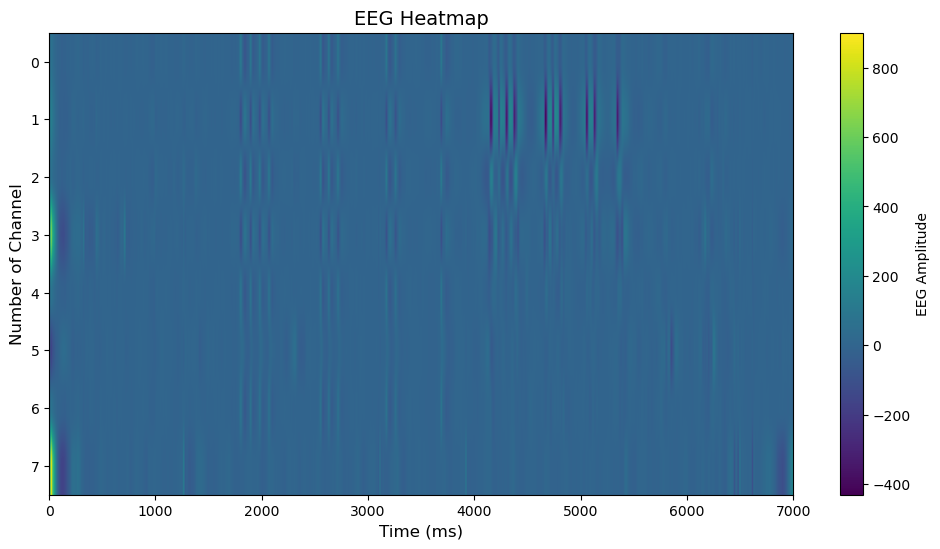

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Adjust the figure size
heatmap = plt.imshow(eeg_data_filtered.T, cmap='viridis', aspect='auto')  # Transpose data for channels as rows
plt.colorbar(heatmap, label='EEG Amplitude')  # Add color bar with label

# Customize axes
plt.xlabel('Time (ms)', fontsize=12)  # Label for the x-axis
plt.ylabel('Number of Channel', fontsize=12)  # Label for the y-axis
plt.title('EEG Heatmap', fontsize=14)  # Title for the heatmap

# Adjust x-axis ticks and limits
plt.xticks(ticks=range(0, eeg_data_filtered.shape[0] + 1, 1000), labels=range(0, 7001, 1000))  # x-axis tick labels
plt.xlim(0, 7000)  # Ensure x-axis spans from 0 to 7000

# Display the heat map
plt.show()

### 3D visualization

3D visualization of EEG data is essential for several reasons:  
Enhanced Data Comprehension: It allows researchers to better understand complex spatial and temporal relationships within the data, providing a clearer overview of how different channels interact over time.  
Pattern Recognition: It aids in identifying patterns and anomalies across multiple channels that might be missed in 2D representations, improving diagnostic accuracy and insight.  
Interactive Exploration: It facilitates interactive exploration, enabling users to rotate and zoom into specific regions of interest, enhancing data analysis and interpretation.

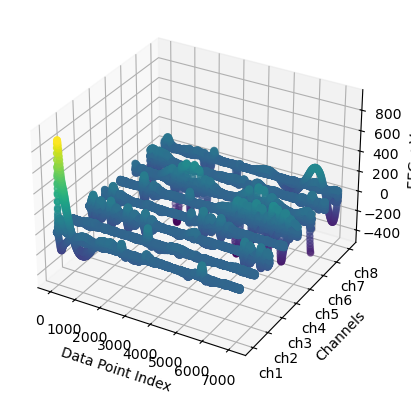

In [22]:
channel_names = ["ch1", "ch2", "ch3", "ch4", "ch5", "ch6", "ch7", "ch8"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(np.arange(channel_data_bp_filtered.shape[0]), np.arange(len(channel_names)))

z = eeg_data_filtered.values.flatten()
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

ax.set_xlabel('Data Point Index')
ax.set_ylabel('Channels')
ax.set_zlabel('EEG, µV')

ax.set_yticks(np.arange(len(channel_names)))
ax.set_yticklabels(channel_names)

plt.show()

### Correlation Matrix
A correlation matrix is a table that shows the pairwise correlation coefficients between variables (in this case, EEG channels). It helps identify relationships or dependencies between channels, which can give insights into brain activity synchronization or interactions.

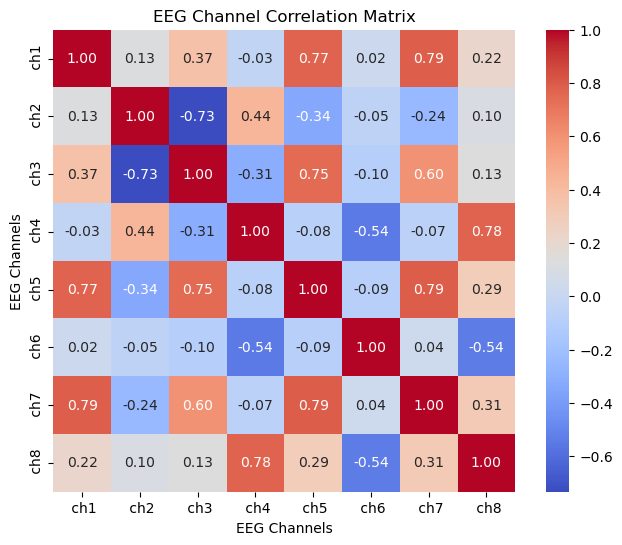

In [24]:
# Calculate the correlation matrix
correlation_matrix = eeg_data_filtered.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("EEG Channel Correlation Matrix")
plt.xlabel("EEG Channels")
plt.ylabel("EEG Channels")
plt.show()

The EEG correlation matrix reveals strong positive correlations between channels like `ch1`, `ch5`, and `ch7`, indicating synchronized activity or shared processing regions. Negative correlations, such as between `ch2` and `ch3`, suggest opposing activity or functional segregation. Channels like `ch6` show weak correlations with others, hinting at isolated activity or noise. Overall, the matrix highlights inter-channel relationships that reflect both cooperative and independent brain dynamics.

### MNE library 
The MNE library  is a powerful open-source tool for processing and analyzing EEG data. It provides efficient methods for data preprocessing, visualization, and advanced analysis, including artifact removal and brain activity mapping. The following code prepares our EEG dataset in a format compatible with MNE, enabling further analysis and visualization.

In [27]:
# Preparing the dataset for MNE library format

# Reshape the data to match the format required for MNE
data_after_band_pass_filter = np.array(eeg_data_filtered)
data_after_band_pass_filter = data_after_band_pass_filter.reshape((8, 7120))
data_after_band_pass_filter = pd.DataFrame(data_after_band_pass_filter)

# Create a standard EEG electrode montage
standard_montage = mne.channels.make_standard_montage('standard_alphabetic')

# Define EEG channel information
n_channels = 8
fake_info = mne.create_info(
    ch_names=["Fp1", "Fz", "Cz", "Pz", "T3", "C3", "C4", "T4"],  # Standard 10-20 system names
    sfreq=250.0,  # Sampling frequency in Hz
    ch_types='eeg'  # EEG channel type
)
print(fake_info)

# Create an Evoked object to represent the EEG data
fake_evoked = mne.EvokedArray(data_after_band_pass_filter, fake_info)

# Set the montage for the Evoked object
fake_evoked.set_montage(standard_montage, on_missing='ignore')

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fz, Cz, Pz, T3, C3, C4, T4
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>


Condition,
Data kind,average
Timepoints,7120 samples
Channels,8 channels
Number of averaged epochs,1
Time range (secs),0.0 – 28.476
Baseline (secs),off


### Spatial distribution of brain activity over the scalp

The EEG script using `times_to_plot` and `fake_evoked.plot_topomap` is essential for visualizing the spatial distribution of brain activity over the scalp at specific time points. The `times_to_plot` array defines the time intervals (0, 7, 14, 21, 28 milliseconds) at which the topographical maps will be plotted. By using fake_evoked.plot_topomap with these parameters, you can observe how the EEG signal changes across different scalp locations and time intervals, providing insights into the temporal dynamics of neural activity. This is particularly useful for identifying patterns and understanding the progression of brain responses over time.

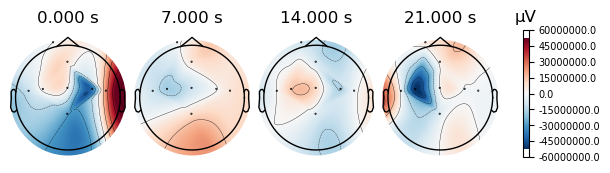

In [29]:
times_to_plot = np.arange(0, 28., 7) #This creates an array of time points: [0, 7, 14, 21]
fake_evoked.plot_topomap(times_to_plot, ch_type="eeg", ncols=len(times_to_plot), nrows="auto"); #This method creates topographic maps of the EEG data